In [76]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

Note: We are assuming the Dataset Contains customer/marketing data as of 10/30/2014. This is also when the latest campaign ended (Campaign 6).  

All of the customers were enrolled during each of the six marketing campaigns. 

Amount spent on wine, meat, fish, sweets, and gold product is over the last two years. For each of the six campaigns, it cost 2 euros to contact a customer and the company receives 22 euros if the customer accepts the offer.

In [77]:
marketing = pd.read_csv('marketing_campaign.csv')
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
ID                     2240 non-null int64
Year_Birth             2240 non-null int64
Education              2240 non-null object
Relationship_Status    2240 non-null object
Income                 2216 non-null float64
Kids                   2240 non-null int64
Teens                  2240 non-null int64
Enroll_Date            2240 non-null object
Recency                2240 non-null int64
Wine ($)               2240 non-null int64
Fruit ($)              2240 non-null int64
Meat ($)               2240 non-null int64
Fish ($)               2240 non-null int64
Sweets ($)             2240 non-null int64
Gold_Products ($)      2240 non-null int64
Discount_Purchases     2240 non-null int64
Web_Purchases          2240 non-null int64
Catalog_Purchases      2240 non-null int64
Store_Purchases        2240 non-null int64
June_Web_Visits        2240 non-null int64
Complaint              2240 

Missing income information for several customers, will utilize average income for their respective education and age.

Age column will be engineered from birth dates into different group values (Ex: 20 - 29, 30 - 39...)

In [78]:
## Checking for any mistaken customer duplicate entries ###
print(max(marketing.ID.value_counts()))

1


In [79]:
### Exploring birth years of customers ###
marketing['Year_Birth'].sort_values(ascending=True)

239     1893
339     1899
192     1900
1950    1940
424     1941
        ... 
747     1995
1850    1995
696     1995
1170    1996
46      1996
Name: Year_Birth, Length: 2240, dtype: int64

The three oldest customers above have most likely passed away, I will exclude them in this study 

In [80]:
marketing = marketing.drop(index=[239, 339, 192], axis=0)

In [81]:
### Creating Age Groups (Do not know which month customers were born, we'll assume they were born after June 30th) ###
marketing['Age'] = 2014 - marketing['Year_Birth']
print('Youngest Customer:', min(marketing['Age']), '\nOldest Customer:', max(marketing['Age']))
marketing['Age_Group'] = ''
for idx, row in marketing.iterrows():
    if 18 <= row['Age'] < 20:
        marketing.loc[idx, 'Age_Group'] = 'Late-Teens'
    elif 20 <= row['Age'] < 30:
        marketing.loc[idx, 'Age_Group'] = 'Twenties'
    elif 30 <= row['Age'] < 40:
        marketing.loc[idx, 'Age_Group'] = 'Thirties'
    elif 40 <= row['Age'] < 50:
        marketing.loc[idx, 'Age_Group'] = 'Forties'
    elif 50 <= row['Age'] < 60:
        marketing.loc[idx, 'Age_Group'] = 'Fifties'
    elif 60 <= row['Age'] < 70:
        marketing.loc[idx, 'Age_Group'] = 'Sixties'
    elif 70 <= row['Age'] < 80:
        marketing.loc[idx, 'Age_Group'] = 'Seventies'
marketing = marketing.drop(['Year_Birth', 'Age'], axis=1)
marketing = marketing[['ID', 'Age_Group', 'Education', 'Relationship_Status', 'Income', 'Kids', 'Teens', 'Enroll_Date', 'Recency', 'Wine ($)', 'Fruit ($)', 'Meat ($)', 'Fish ($)', 'Sweets ($)', 'Gold_Products ($)', 'Discount_Purchases', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'June_Web_Visits', 'Campaign1', 'Campaign2', 'Campaign3', 'Campaign4', 'Campaign5', 'Campaign6', 'Complaint', 'Contact_Cost', 'Offer_Revenue']]
print(marketing.groupby('Age_Group')['Age_Group'].count().sort_values(ascending=False))


Youngest Customer: 18 
Oldest Customer: 74
Age_Group
Forties       676
Thirties      557
Fifties       467
Sixties       300
Twenties      214
Seventies      16
Late-Teens      7
Name: Age_Group, dtype: int64


Most customers are in their forties

In [82]:
### Simplifying Relationship status ###
for idx, row in marketing.iterrows():
    if row['Relationship_Status'] == 'YOLO' or row['Relationship_Status'] == 'Alone' or row['Relationship_Status'] == 'Absurd':
        marketing.loc[idx, 'Relationship_Status'] = 'Single'
    elif row['Relationship_Status'] == 'Together':
        marketing.loc[idx, 'Relationship_Status'] = 'In-Relationship'
print(marketing.groupby('Relationship_Status')['Relationship_Status'].count().sort_values(ascending=False))


Relationship_Status
Married            864
In-Relationship    579
Single             486
Divorced           231
Widow               77
Name: Relationship_Status, dtype: int64


count      2237.000000
mean      52239.753759
std       25046.050354
min        1730.000000
25%       35523.000000
50%       51390.000000
75%       68281.000000
max      666666.000000
Name: Income, dtype: float64

^^^Max Income of 666666.0 is 4.105162041170711 greater than the second highest income of 162397.0

This one very wealthy individual is skewing our distribution and descriptive statistics. While it may be possible that one of the countrys wealthiest individuals shops at this store, I chose to exclude he/she from this analysis as they did not respond to any of the 6 campaigns for the offer


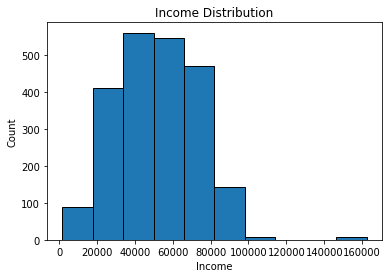

count      2236.000000
mean      51964.965635
std       21414.882468
min        1730.000000
25%       35502.500000
50%       51381.500000
75%       68275.750000
max      162397.000000
Name: Income, dtype: float64


In [83]:
### Imputing missing Income values based on education & age group ###
import matplotlib.pyplot as plt

marketing = marketing.fillna(0)
for idx, row in marketing.iterrows():
    if row['Income'] == 0:
        education = row['Education']
        age_group = row['Age_Group']
        df = marketing.loc[(marketing['Education'] == education) & (marketing['Age_Group'] == age_group)]
        marketing.loc[idx, 'Income'] = np.mean(df['Income'])
print(marketing['Income'].describe())
income = sorted(list(marketing['Income'].values))
print('\n^^^Max Income of', max(income), 'is', max(income)/income[-2], 'greater than the second highest income of', income[-2])
print('\nThis one very wealthy individual is skewing our distribution and descriptive statistics. While it may be possible that one of the countrys wealthiest individuals shops at this store, I chose to exclude he/she from this analysis as they did not respond to any of the 6 campaigns for the offer')
marketing = marketing.loc[~(marketing['Income'] == 666666)]
plt.hist(marketing['Income'], edgecolor='black')
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()
print(marketing['Income'].describe())

C:\Users\Rachid\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Rachid\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


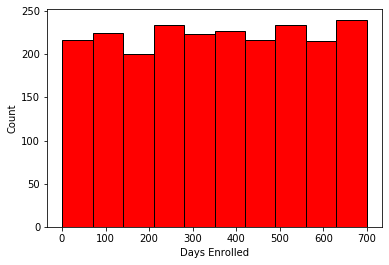

count    2232.000000
mean      354.651882
std       202.214846
min         1.000000
25%       181.750000
50%       356.500000
75%       530.000000
max       700.000000
Name: Days_Enrolled, dtype: float64 

Customer acquisition rate has been relatively steady.


In [84]:
### Using Enrollment Date to get idea of how long customers have been enrolled with the store ###
from datetime import datetime

date1 = datetime.strptime('2014-06-30', "%Y-%m-%d").date()
marketing['Enroll_Date'] = pd.to_datetime(marketing['Enroll_Date']).dt.date

def numOfDays(date1, date2): 
    return abs(date2-date1).days

num_of_days = []
for value in list(marketing['Enroll_Date'].values):
    days = numOfDays(date1, value)
    num_of_days.append(days)
    
marketing['Days_Enrolled'] = pd.Series([int(d) for d in num_of_days])
plt.hist(marketing['Days_Enrolled'], edgecolor='black', color='red')
plt.xlabel('Days Enrolled')
plt.ylabel('Count')
plt.show()
print(marketing['Days_Enrolled'].describe(), '\n\nCustomer acquisition rate has been relatively steady.')

In [85]:
### Engineering some more features: Average Purchase Frequency and Average Spend on a Purchase ###
marketing['Total Spent ($)'] = marketing['Wine ($)'] + marketing['Fruit ($)'] + marketing['Meat ($)'] + marketing['Fish ($)'] + marketing['Sweets ($)'] + marketing['Gold_Products ($)']
marketing['Number_Purchases'] = marketing['Discount_Purchases'] + marketing['Web_Purchases'] + marketing['Catalog_Purchases'] + marketing['Store_Purchases']
marketing['Avg_Purch_Freq'] = (marketing['Days_Enrolled'] / marketing['Number_Purchases']).replace(np.inf, np.nan)
marketing['Avg_Spend ($)'] = (marketing['Total Spent ($)'] / marketing['Number_Purchases']).replace(np.inf, np.nan)
marketing = marketing.drop(['Total Spent ($)', 'Number_Purchases'], axis=1)

Upon examining the average spend data, the max average spend was 1,679 on one single purchase for a customer who had enrolled in 2012. The next highest average spend is 187, so I'm choosing to beleive this customer will not return and we can exclude them from analysis. Customers who have never made a single purchase were also excluded. In total this was just 5 customers that were excluded. 

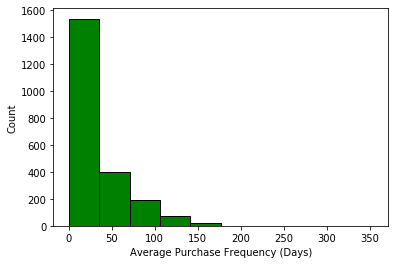

count    2227.000000
mean       33.847326
std        32.778878
min         0.052632
25%        12.404545
50%        23.521739
75%        43.033333
max       354.000000
Name: Avg_Purch_Freq, dtype: float64


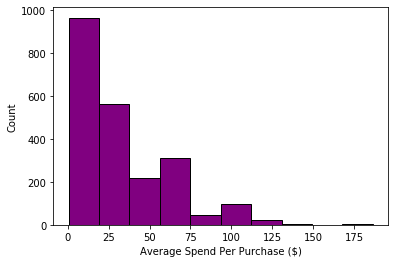

count    2231.000000
mean       32.587883
std        28.511521
min         0.533333
25%         9.714286
50%        23.384615
75%        45.281773
max       186.500000
Name: Avg_Spend ($), dtype: float64


In [86]:
marketing = marketing.loc[~((marketing['Avg_Spend ($)'] == 1679) | (marketing['Avg_Spend ($)'].isnull()))]
plt.hist(marketing['Avg_Purch_Freq'], bins=10, edgecolor='black', color='green')
plt.ylabel('Count')
plt.xlabel('Average Purchase Frequency (Days)')
plt.show()
print(marketing['Avg_Purch_Freq'].describe())
plt.hist(marketing['Avg_Spend ($)'], edgecolor='black', color='purple')
plt.ylabel('Count')
plt.xlabel('Average Spend Per Purchase ($)')
plt.show()
print(marketing['Avg_Spend ($)'].describe())

In [87]:
### Analyzing the 6 campaigns by Profit/Loss and Acceptance % ###
cost_contact = 2
revenue = 22
campaigns = ['Campaign1', 'Campaign2', 'Campaign3', 'Campaign4', 'Campaign5', 'Campaign6']
for campaign in campaigns:
    costs = len(marketing[campaign]) * cost_contact
    rev = sum(marketing[campaign]) * revenue
    profit = rev - costs
    acceptance = sum(marketing[campaign])/len(marketing[campaign]) * 100
    print('*' + str(campaign) + '*' + '\nProfit/Loss:', profit, 'Acceptance (%):', acceptance) 

*Campaign1*
Profit/Loss: -876 Acceptance (%): 7.306140744060959
*Campaign2*
Profit/Loss: -810 Acceptance (%): 7.440609592111161
*Campaign3*
Profit/Loss: -898 Acceptance (%): 7.261317794710892
*Campaign4*
Profit/Loss: -1294 Acceptance (%): 6.454504706409682
*Campaign5*
Profit/Loss: -3802 Acceptance (%): 1.344688480502017
*Campaign6*
Profit/Loss: 2886 Acceptance (%): 14.970865082922458


In [88]:
### Adding Acceptance (%) for each customer after the six campaigns ###
marketing['Cust_Accept (%)'] = 0
marketing['Accept_One'] = 0
for idx, row in marketing.iterrows():
    acceptance_count = 0
    for campaign in campaigns:
        if row[campaign] == 1:
            acceptance_count += 1
    if acceptance_count > 0:
        marketing.loc[idx, 'Accept_One'] = 1
    acceptance_rate = (acceptance_count / 6) * 100
    marketing.loc[idx, 'Cust_Accept (%)'] = acceptance_rate
print(marketing['Cust_Accept (%)'].describe())
num_acc = sum(marketing['Accept_One'])
print('\nValue Counts (%)\n', marketing['Cust_Accept (%)'].value_counts())
print('\n', num_acc, 'customers accepted the offer at least once during the six campaigns')

sum_accepted = 0
total_attempts = 6 * len(marketing)
for campaign in campaigns:
    sum_accepted += sum(marketing[campaign])
overall = sum_accepted / total_attempts * 100
print('\nThe offer was accepted', sum_accepted, 'times out of', total_attempts, 'attempts for an overall acceptance percentage of', str(round(overall, 2)) + '% and an overall loss of', (sum_accepted * 22) - (total_attempts * 2))
marketing.to_csv('test.csv', index=False)

count    2231.000000
mean        7.463021
std        14.863884
min         0.000000
25%         0.000000
50%         0.000000
75%        16.666667
max        83.333333
Name: Cust_Accept (%), dtype: float64

Value Counts (%)
 0.000000     1624
16.666667     368
33.333333     142
50.000000      51
66.666667      36
83.333333      10
Name: Cust_Accept (%), dtype: int64

 607 customers accepted the offer at least once during the six campaigns

The offer was accepted 999 times out of 13386 attempts for an overall acceptance percentage of 7.46% and an overall loss of -4794


  Age_Group  Acceptance %  Total Customers
    Fifties     29.336188              467
    Sixties     28.762542              299
    Forties     26.557864              674
   Thirties     24.909747              554
   Twenties     25.700935              214
  Seventies     56.250000               16
 Late-Teens     42.857143                7


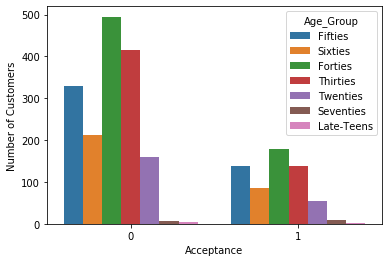

In [89]:
import seaborn as sns
import collections

ax = sns.countplot('Accept_One', hue='Age_Group', data=marketing)
plt.ylabel('Number of Customers')
plt.xlabel('Acceptance')

dict_percent = collections.defaultdict(list)
for category in list(marketing['Age_Group'].unique()):
    dict_percent['Age_Group'].append(category)
    total = len(marketing.loc[marketing['Age_Group'] == category])
    accept = len(marketing.loc[(marketing['Age_Group'] == category) & (marketing['Accept_One'] == 1)])
    percent = (accept / total) * 100
    dict_percent['Acceptance %'].append(percent)
    dict_percent['Total Customers'].append(total)

df_percents = pd.DataFrame(dict_percent)
print(df_percents.to_string(index=False))



  Education  Acceptance %  Total Customers
 Graduation     26.536064             1123
        PhD     32.438017              484
     Master     27.027027              370
      Basic     12.962963               54
   2n Cycle     22.500000              200


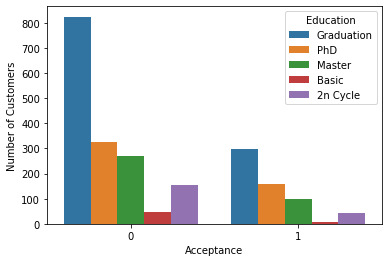

In [90]:
ax = sns.countplot('Accept_One', hue='Education', data=marketing)
plt.ylabel('Number of Customers')
plt.xlabel('Acceptance')

dict_percent = collections.defaultdict(list)
for category in list(marketing['Education'].unique()):
    dict_percent['Education'].append(category)
    total = len(marketing.loc[marketing['Education'] == category])
    accept = len(marketing.loc[(marketing['Education'] == category) & (marketing['Accept_One'] == 1)])
    percent = (accept / total) * 100
    dict_percent['Acceptance %'].append(percent)
    dict_percent['Total Customers'].append(total)

df_percents = pd.DataFrame(dict_percent)
print(df_percents.to_string(index=False))


Relationship_Status  Acceptance %  Total Customers
             Single     31.134021              485
    In-Relationship     24.783362              577
            Married     25.144844              863
           Divorced     30.131004              229
              Widow     35.064935               77


'Offer seemed to be more successful with single individuals'

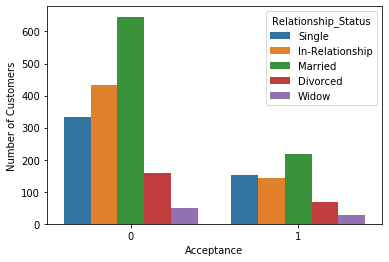

In [91]:
ax = sns.countplot('Accept_One', hue='Relationship_Status', data=marketing)
plt.ylabel('Number of Customers')
plt.xlabel('Acceptance')

dict_percent = collections.defaultdict(list)
for category in list(marketing['Relationship_Status'].unique()):
    dict_percent['Relationship_Status'].append(category)
    total = len(marketing.loc[marketing['Relationship_Status'] == category])
    accept = len(marketing.loc[(marketing['Relationship_Status'] == category) & (marketing['Accept_One'] == 1)])
    percent = (accept / total) * 100
    dict_percent['Acceptance %'].append(percent)
    dict_percent['Total Customers'].append(total)

df_percents = pd.DataFrame(dict_percent)
print(df_percents.to_string(index=False))
'Offer seemed to be more successful with single individuals'